# Estudio de Ondas Gravitacionales usando Homología Persistente

### Sergio Nieto, UNAM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson07_topological-time-series.ipynb)

## Objetivo

> La idea es usar características topológicas en los diagramas de persistencia para agregarlos a un vector de serie de tiempo asociado a una onda gravitacional. Con esta información adicional se espera que mejore un algoritmo de clasificación que de una probabilidad de contener en la señal evidencia de una onda gravitacional.

## Plan

1. Ondas gravitacionales
2. Como usar TDA en series de tiempo (una forma)
3. Pipeline del artículo
4. Hands-on

## Referencias

Las referencias principales son:

* [_Detection of gravitational waves using topological data analysis and convolutional
neural network: An improved approach_](https://arxiv.org/pdf/1910.08245.pdf) by C. Bresten and J.H.Jung. 

* [Deep Learning for Real-time Gravitational Wave Detection and Parameter Estimation:
Results with Advanced LIGO Data.](https://www.semanticscholar.org/reader/9e9ed1fa26156c9ca01ff80f522d95b794835d13)

## Referencias

La idea de usar ventanas móviles para generar nubes de puntos esta formalizada en el artículo de Perea y Harer:
* [_Sliding Windows and Persistence: An Application of Topological Methods to Signal Analysis_](https://arxiv.org/abs/1307.6188) by J. Perea and J.Harer.

* Hay unos notebooks que sirven de ejemplos para el tema de las ventanas móviles: C. Tralie's [TDALabs](https://github.com/ctralie/TDALabs)

## Referencias Varias

Relatividad:
* [_Lecture Notes on General Relativity_](https://arxiv.org/pdf/gr-qc/9712019.pdf) by Sean Carroll, Chapter 6.

* Hay unos notebooks que sirven de ejemplos para el tema de las ventanas móviles: C. Tralie's [TDALabs](https://github.com/ctralie/TDALabs)

### Disclaimer a las referencias

Me encontré con la librería de python [_hepml: Practical ML for physicists_](https://github.com/lewtun/hepml) y esta contiene un notebook que precisamente hace el análsis análogo del artículo mencionado. __No pude evitar usarlo__ como template ya que usan un método que les permite simular las series de tiempo.

# Detección de Ondas Gravitacionales


![SegmentLocal](2mergers.gif "segment")

![](einstein_gw.PNG)
<div style="text-align: center">
   
</div>

### ¡En 2015, se detectaron señales de ondas gravitacionales!

![SegmentLocal](ligo_detection.gif "segment")

¡En 2015, se detectaron señales de ondas gravitacionales!
![](ligo_cdmx.PNG)
<div style="text-align: center">
   
</div>

## Relatividad numérica

En realidad no sabemos qué buscar dentro de todo el ruido que llega.

* Se necesita la expresión matemática del evento astonómico o en este caso la simulación numérica correspondiente.

> Resolver las ecuaciones de campo para colisiones estelares o colisiones de agujeros negros es muy muy difícil.

## Relatividad numérica

* Una simulación exitosa solo se logró hasta 2005-2007.

* Actualmente se tiene el _Einstein Spectral Code_ https://www.black-holes.org/code/SpEC.html



In [1]:
# data wrangling
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import YouTubeVideo
from fastprogress import progress_bar

# hepml
from hepml.core import make_gravitational_waves, download_dataset


# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

In [2]:
np.random.seed(2022)

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

As a warmup, let's generate some noisy signals with a constant signal-to-noise ratio (SNR) of 17.98. As shown in the table below, this corresponds to an $R$ value of 0.65. By picking the upper end of the interval, we can gain a sense for what is best possible performance for our time series clasifier.

In [3]:
DATA = Path("./data")
#
download_dataset('gravitational-wave-signals.npy')

Dataset already exists at '../data/gravitational-wave-signals.npy' and is not downloaded again.


In [4]:
n_signals = 1000

noisy_signals, gw_signals, labels = make_gravitational_waves(path_to_data=DATA, 
                                                             n_signals=n_signals,# 
                                                            )

signals_df = pd.DataFrame(noisy_signals)
#np.linspace(r_min, r_max, n_snr_values)
print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 1000
Number of timesteps per series: 8692


In [41]:
np.linspace(.03, .65, 1)

array([0.03])

<AxesSubplot:>

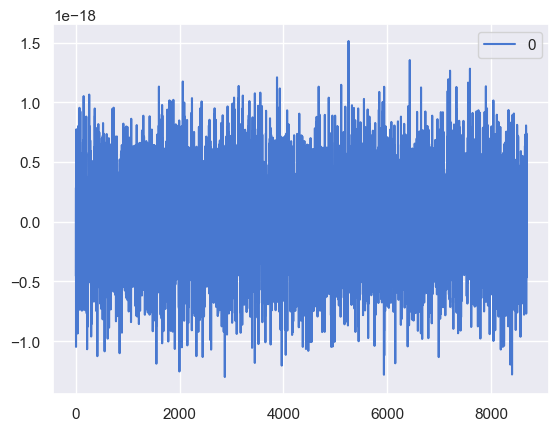

In [15]:
pd.DataFrame(noisy_signals[233]).plot()

<AxesSubplot:>

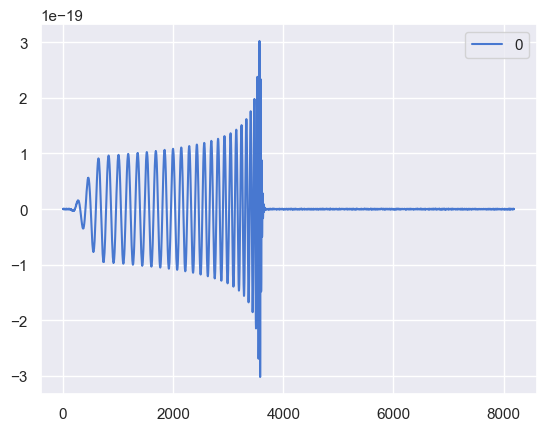

In [20]:
pd.DataFrame(gw_signals[233]).plot()

In [38]:
labels.sum(), len(labels) - labels.sum()

(328.0, 322.0)

In [101]:
labels[0:9]

array([1., 1., 0., 1., 1., 1., 0., 1., 0.])

In [185]:
noisy_signals[333][0:5]*(1e18)

array([ 0.10309493, -0.66256069, -0.11193555,  0.18282731, -0.14834248])

In [ ]:
'''from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series.reshape(-1, 1)).reshape(-1)
plot([series, scaled_series], ['original', 'scaled'])'''

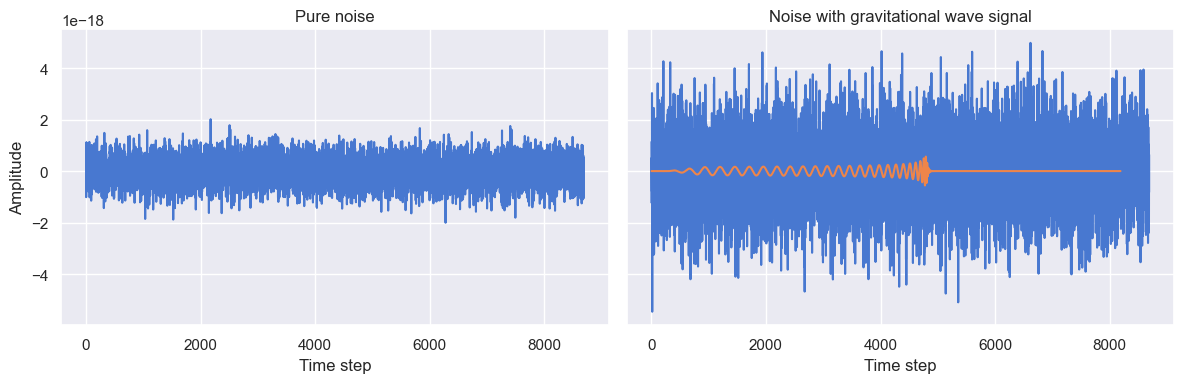

In [102]:
background_idx = np.argmin(labels) # index of the first pure noise time series
signal_idx = np.argmax(labels) # index of the first noise + gravitational wave time series
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
ax0.plot(noisy_signals[background_idx])
ax0.set_ylabel("Amplitude")
ax0.set_xlabel("Time step")
ax0.set_title("Pure noise")
ax1.plot(noisy_signals[0])
ax1.plot(gw_signals[signal_idx])
ax1.set_xlabel("Time step")
ax1.set_title("Noise with gravitational wave signal")
plt.tight_layout()

## Cómo usamos HP en series de Tiempo?

### De Series a Nubes de Puntos

Una señal en series de tiempo se representa como:

$$ f: I \to \mathbb{R}$$

Sea $\tau>0$ y $M>0$ un entero, se llama _**Sliding window embedding**_ o encaje de $f$ con parámetros $(M,\tau)$ a la función:

$$
SW_{M,\tau} f : \mathbb{R} \to \mathbb{R}^{M+1}\,, \qquad t \to \begin{bmatrix}
           f(t) \\
           f(t + \tau) \\
           f(t + 2\tau) \\
           \vdots \\
           f(t + M\tau)
         \end{bmatrix}
$$



> La hipotesis es que si $f$ tiene estructura no trivial, entonces $SW_{M,\tau}f$ tiene topología no trivial, para elecciones adecuadas de $(M, \tau)$.

In [5]:
# tda 
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.plotting import plot_heatmap, plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding, SingleTakensEmbedding

# ml 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, roc_auc_score, accuracy_score

## Ejemplos para entender el encaje

Encaje de Takens. Una "ventana" se mapea a un punto en $\mathbb{R}^{m+1}$:

![](sliding_window_embedding.png)
<div style="text-align: center">
   <p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/3easx09 </p>
</div>

 $f(t) = \cos(5 t)$

In [48]:
x_periodic = np.linspace(0, 30, 1000)
y_periodic = np.cos(x_periodic)

print(f"puntos de la sucesión: {len(y_periodic)}")

puntos de la sucesión: 1000


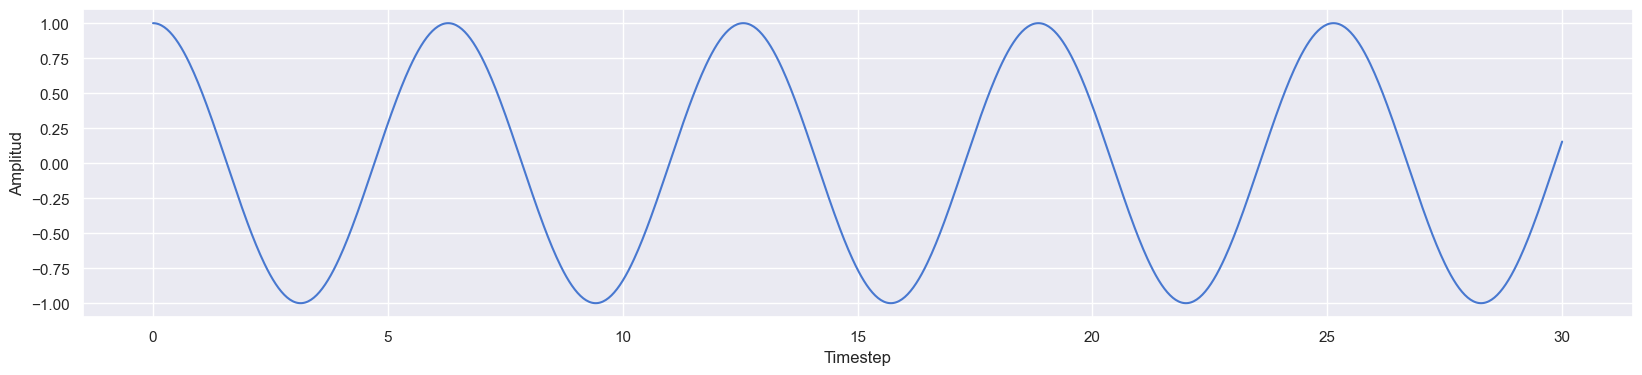

In [49]:
plt.figure(figsize=(20, 4))
plt.plot(x_periodic, y_periodic)
plt.xlabel("Timestep")
plt.ylabel("Amplitud")
plt.show()

- Como la serie tiene estructura recurrente o periodica, entonces esperamos que en algun $\mathbb{R}^{m+1}$ la topología sea reconocible:

In [73]:
embedding_dimension = 3 # encajamos en R^3
embedding_time_delay = 5
stride = 5 # cuanto movemos la ventana a la derecha

embedder_periodic = SingleTakensEmbedding( #Single es para arreglos de dim 1
    
    #parameters_type="fixed",
    n_jobs=-1,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride
)
# Lo anterior solo define la instancia del encaje, no hemos hecho nada aun

> el `stride` no solo es el salto entre ventanas, sirve para no tener que recorrer las ventanas en tooodoso los valores, es también una estrategia de muestreo.

In [83]:
y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
y_periodic_embedded[0:5] # Para ver realmente estamos en dim 3

array([[0.99279425, 0.96369877, 0.91291743],
       [0.96369877, 0.91291743, 0.84159294],
       [0.91291743, 0.84159294, 0.7513303 ],
       [0.84159294, 0.7513303 , 0.64416067],
       [0.7513303 , 0.64416067, 0.52249566]])

In [57]:
plot_point_cloud(y_periodic_embedded)

La periodicidad de $f$ se refleja en en el encaje como una estructura casi circular. En general, será que funciones periódicas encajan en estructuras esfericas o elipsoides en $\mathbb{R}^{M+1}$ ??

In [60]:
x_nonperiodic = np.linspace(0, 50, 1000)
y_nonperiodic = np.cos(2*x_nonperiodic) + np.cos(np.pi * x_nonperiodic)

print(f"puntos de la sucesión: {len(y_nonperiodic)}")

puntos de la sucesión: 1000


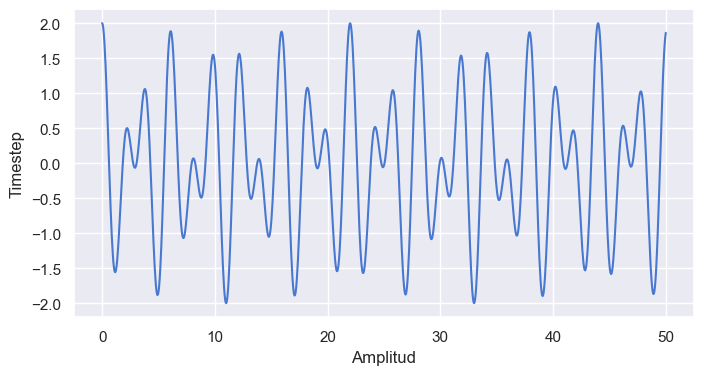

In [61]:
plt.figure(figsize=(8, 4))
plt.plot(x_nonperiodic, y_nonperiodic)
plt.xlabel("Amplitud")
plt.ylabel("Timestep")
plt.show()

In [84]:
embedder_noncosine = SingleTakensEmbedding(
    #parameters_type="fixed",
    n_jobs=-1,
    time_delay=10,
    dimension=3,
    stride=5,
)
y_nonperiodic_embedded = embedder_noncosine.fit_transform(y_nonperiodic)
y_nonperiodic_embedded.shape

(196, 3)

In [76]:
plot_point_cloud(y_nonperiodic_embedded)

## De Nubes a Diagramas 

En la librería de giotto-tda, la filtración de Vietoris-Rips necesita de input arreglos de la forma `(n_samples, n_points, n_dimensions)`

In [85]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

# Tienen la forma adecuada?
y_periodic_embedded.shape, y_nonperiodic_embedded.shape

# No ejecutar mas de 1 vez...

((1, 198, 3), (1, 196, 3))

Para calcular el diagrama de persistencia se llama `VietorisRipsPersistence` y se usa el metodo fit_transform para generar la filtración y el diagrama correspondiente.

In [86]:
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, 
                                               n_jobs=-1)

%time periodic_persistence_diagrams = periodic_persistence.fit_transform(y_periodic_embedded)

CPU times: user 5.85 ms, sys: 4.93 ms, total: 10.8 ms
Wall time: 515 ms


In [87]:
nonperiodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, 
                                                  n_jobs=-1)

%time nonperiodic_persistence_diagrams = nonperiodic_persistence.fit_transform(y_nonperiodic_embedded)

CPU times: user 3.72 ms, sys: 2.08 ms, total: 5.79 ms
Wall time: 409 ms


In [93]:
periodic_persistence_diagrams

array([[[0.        , 0.00489452, 0.        ],
        [0.        , 0.00489866, 0.        ],
        [0.        , 0.0049327 , 0.        ],
        [0.        , 0.00501222, 0.        ],
        [0.        , 0.00513112, 0.        ],
        [0.        , 0.00528668, 0.        ],
        [0.        , 0.0054757 , 0.        ],
        [0.        , 0.00598809, 0.        ],
        [0.        , 0.00626101, 0.        ],
        [0.        , 0.00655369, 0.        ],
        [0.        , 0.00686346, 0.        ],
        [0.        , 0.00718796, 0.        ],
        [0.        , 0.00745838, 0.        ],
        [0.        , 0.00752512, 0.        ],
        [0.        , 0.00780441, 0.        ],
        [0.        , 0.00787315, 0.        ],
        [0.        , 0.00816005, 0.        ],
        [0.        , 0.00852391, 0.        ],
        [0.        , 0.0088948 , 0.        ],
        [0.        , 0.00927169, 0.        ],
        [0.        , 0.00965368, 0.        ],
        [0.        , 0.0105019 , 0

In [95]:
plot_diagram(periodic_persistence_diagrams[0])

In [96]:
plot_diagram(nonperiodic_persistence_diagrams[0])

Ahí esta el detalle:

* Hay diferentes dimensiones topológicas persistentes.

* Caso A: 1 cíclo persistente

* Caso B: 2 cíclos de dim 2 = huecos

> Al ser diferentes características topológicas podemos decir que las series originales son _diferentes entre sí_

## Gravitational wave detection

As an application of the above ideas, let's examine how persistent homology can help detect gravitational waves in noisy signals. The following is adapted from the [article](https://arxiv.org/pdf/1910.08245.pdf) by C. Bresten and J.H. Jung.

Let's examine what the sliding window embedding of a pure gravitational wave signal looks like:

In [6]:
def fit_embedder(embedder, y, verbose=True):
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}")

    return y_embedded

In [98]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", 
    n_jobs=-1, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

%time y_gw_embedded = fit_embedder(embedder, gw_signals[0])

Shape of embedded time series: (1529, 20)
Optimal embedding dimension is 20 and time delay is 29
CPU times: user 105 ms, sys: 87.2 ms, total: 192 ms
Wall time: 2.32 s


As we did in our simple examples, we can use PCA to project our high-dimensional space to 3-dimensions for visualisation:

In [99]:
pca = PCA(n_components=3)
y_gw_embedded_pca = pca.fit_transform(y_gw_embedded)

plot_point_cloud(y_gw_embedded_pca)

In [106]:
labels[0:9]

array([1., 1., 0., 1., 1., 1., 0., 1., 0.])

In [108]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=-1, 
    time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = fit_embedder(embedder, noisy_signals[8]) #signal_idx

pca = PCA(n_components=3)
y_noise_embedded_pca = pca.fit_transform(y_noise_embedded)

plot_point_cloud(y_noise_embedded_pca)

Shape of embedded time series: (1720, 7)
Optimal embedding dimension is 7 and time delay is 16


Evidently pure noise resembles a high-dimensional ball in the sliding window embedding space. Let's see if we can use persistent homology to tease apart which time series contain a gravitational wave signal versus those that don't. To do so we will adapt the strategy from the original article:

1. Generate 200-dimensional sliding window embeddings of each time series
2. Use PCA to reduce the sliding window embeddings to 3-dimensions
3. Use the Vietoris-Rips construction to calculate persistence diagrams of $H_0$ and $H_1$ generators
4. Extract feature vectors using persistence entropy
5. Train a binary classifier on the topological features

### Create sliding window embeddings

In [7]:
# Elecciones del paper
embedding_dimension = 200
embedding_time_delay = 10
stride = 10

point_clouds = []

for i in progress_bar(range(len(noisy_signals))):

    embedder = SingleTakensEmbedding(
        parameters_type="fixed", n_jobs=-1, 
        time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
    )

    pca = PCA(n_components=3)
    point_clouds.append(pca.fit_transform(fit_embedder(embedder, noisy_signals[i], verbose=False)))

point_clouds = np.asarray(point_clouds)
point_clouds.shape

(1000, 671, 3)

### Homologia Persistente

In [8]:
vripsper = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

In [9]:
len(point_clouds[1])

671

In [10]:
%time diagramas_rips = vripsper.fit_transform(point_clouds)

CPU times: user 2.61 s, sys: 349 ms, total: 2.95 s
Wall time: 1min 7s


In [179]:
diagramas_rips[2]

array([[0.00000000e+00, 1.78512281e-20, 0.00000000e+00],
       [0.00000000e+00, 2.57753857e-20, 0.00000000e+00],
       [0.00000000e+00, 3.75690151e-20, 0.00000000e+00],
       ...,
       [2.09811745e-20, 2.09811745e-20, 1.00000000e+00],
       [2.09811745e-20, 2.09811745e-20, 1.00000000e+00],
       [2.09811745e-20, 2.09811745e-20, 1.00000000e+00]])

In [115]:
from gtda.plotting import plot_diagram

i = np.random.choice(range(0, len(point_clouds), 1))
print(i)
plot_diagram(diagramas_rips[2])

643


In [11]:
from sklearn.utils import resample

In [12]:
lista_larga = []
for i in range(0, len(diagramas_rips)): 
    vector_diag = []
    diagrams_i = pd.DataFrame(diagramas_rips[i], 
                                 columns=['birth', 'death', 'h'])

    df_majority = diagrams_i[diagrams_i.h==0].sort_values(by=['death'], 
                                                        ascending=False)
    df_minority = diagrams_i[diagrams_i.h==1].sort_values(by=['death'], 
                                                        ascending=False)
    #df_voids = diagrams_i[diagrams_i.h==2]

    N_p = int(np.floor(len(diagrams_i[diagrams_i['h'] == 1])*(.95)))

    df_min_downsampled = resample(df_minority, 
                            replace=False,
                            n_samples=N_p,     # to match minority class
                            random_state=2022)

    df_majority_downsampled = resample(df_majority, 
                            replace = False,
                            n_samples = N_p, #len(diagrams_i[diagrams_i['h'] == 1]),
                                       # to match minority class
                            random_state = 2022) # reproducible results

    df_downsampled = pd.concat([df_majority_downsampled, df_min_downsampled])
    diagrams_vals = df_downsampled.values
    #break
    for k in range(0, int(len(diagrams_vals)) ): 
        vector_diag.extend(diagrams_vals[k][0:2])
        #break
    lista_larga.append(vector_diag)
    #break

<AxesSubplot:>

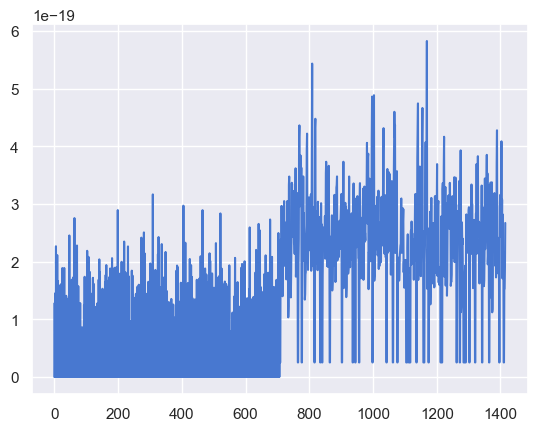

In [13]:
indice_d = np.random.choice(range(0, len(point_clouds), 1))
pd.DataFrame((lista_larga)).iloc[indice_d].plot()

In [14]:
PI_01 = pd.DataFrame(lista_larga)
PI_01.columns = ['c_'+str(x) for x in PI_01.columns]
PI_01.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_1406,c_1407,c_1408,c_1409,c_1410,c_1411,c_1412,c_1413,c_1414,c_1415
0,0.0,5.709916e-19,0.0,6.440730e-19,0.0,1.047233e-18,0.0,5.790855e-19,0.0,9.657248e-19,...,9.289720e-19,1.193962e-18,8.652452e-19,9.030381e-19,2.527198e-20,2.527198e-20,2.527198e-20,2.527198e-20,9.841074e-19,1.153539e-18
1,0.0,2.873037e-19,0.0,3.381165e-19,0.0,5.544680e-19,0.0,2.927968e-19,0.0,5.049835e-19,...,6.145878e-19,6.373030e-19,4.139671e-19,4.448224e-19,2.527198e-20,2.527198e-20,2.527198e-20,2.527198e-20,5.177705e-19,5.958164e-19
2,0.0,2.108842e-19,0.0,2.369110e-19,0.0,4.175397e-19,0.0,2.164182e-19,0.0,3.642885e-19,...,3.728741e-19,4.201892e-19,3.163846e-19,3.185587e-19,2.527198e-20,2.527198e-20,2.527198e-20,2.527198e-20,3.768106e-19,4.055917e-19
3,0.0,1.433031e-19,0.0,1.596214e-19,0.0,2.580449e-19,0.0,1.451899e-19,0.0,2.338030e-19,...,2.736476e-19,3.199298e-19,2.167786e-19,2.233912e-19,2.527198e-20,2.527198e-20,2.527198e-20,2.527198e-20,2.859445e-19,3.012464e-19
4,0.0,1.207754e-19,0.0,1.379936e-19,0.0,2.278169e-19,0.0,1.228682e-19,0.0,2.149116e-19,...,1.986767e-19,2.607103e-19,1.595412e-19,1.766839e-19,2.527198e-20,2.527198e-20,2.527198e-20,2.527198e-20,1.936423e-19,2.463096e-19


In [15]:
from sklearn.preprocessing import MinMaxScaler
std_test = MinMaxScaler().fit_transform(PI_01.transpose())
P1_norm = pd.DataFrame(std_test).transpose()

In [16]:
P1_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415
0,0.0,0.164925,0.0,0.186034,0.0,0.302482,0.0,0.167263,0.0,0.278939,...,0.268324,0.344863,0.249917,0.260833,0.007300,0.007300,0.007300,0.007300,0.284249,0.333187
1,0.0,0.197204,0.0,0.232082,0.0,0.380585,0.0,0.200975,0.0,0.346619,...,0.421851,0.437443,0.284146,0.305325,0.017347,0.017347,0.017347,0.017347,0.355396,0.408967
2,0.0,0.225250,0.0,0.253050,0.0,0.445983,0.0,0.231161,0.0,0.389104,...,0.398275,0.448813,0.337937,0.340259,0.026994,0.026994,0.026994,0.026994,0.402480,0.433221
3,0.0,0.208625,0.0,0.232382,0.0,0.375670,0.0,0.211372,0.0,0.340378,...,0.398385,0.465763,0.315593,0.325220,0.036792,0.036792,0.036792,0.036792,0.416287,0.438564
4,0.0,0.256012,0.0,0.292511,0.0,0.482913,0.0,0.260449,0.0,0.455557,...,0.421143,0.552638,0.338186,0.374524,0.053570,0.053570,0.053570,0.053570,0.410471,0.522112


In [136]:
#PI_norm = PI_01.div(PI_01.sum(axis=1), axis=0)

#for i in range(0,len(signals_df)):
  #print(i)
  #print(PI_01.iloc[i])
  #max_i = max(signals_df.iloc[i])
  #signals_df.iloc[i] = signals_df.iloc[i]/max_i

P1_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431
0,0.0,0.268877,0.0,0.303871,0.0,0.462684,0.0,0.274845,0.0,0.431627,...,0.485728,0.569917,0.426736,0.441595,0.009584,0.009584,0.321110,0.327380,0.409956,0.547741
1,0.0,0.261826,0.0,0.297826,0.0,0.471499,0.0,0.270626,0.0,0.430919,...,0.487933,0.541160,0.297896,0.310919,0.018901,0.018901,0.018901,0.018901,0.505056,0.508486
2,0.0,0.206284,0.0,0.239221,0.0,0.450319,0.0,0.209737,0.0,0.423995,...,0.416176,0.487189,0.286477,0.336891,0.023099,0.023099,0.219377,0.250062,0.430806,0.450906
3,0.0,0.175952,0.0,0.203065,0.0,0.391043,0.0,0.180592,0.0,0.328989,...,0.317095,0.384166,0.296770,0.300353,0.022839,0.022839,0.234356,0.243740,0.330719,0.369260
4,0.0,0.221991,0.0,0.253441,0.0,0.375632,0.0,0.227823,0.0,0.351366,...,0.429823,0.514310,0.340560,0.350117,0.037741,0.037741,0.037741,0.037741,0.464831,0.493259


<AxesSubplot:>

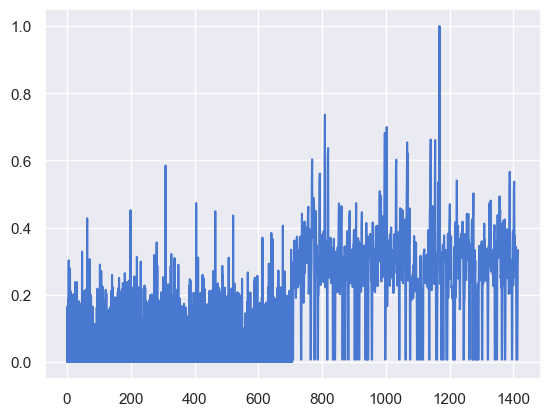

In [17]:
P1_norm.iloc[0,:].plot()

In [18]:
signals_df.columns = ['sig_'+str(x) for x in signals_df.columns]
mm_test = MinMaxScaler().fit_transform(signals_df.transpose())
signals_df_norm = pd.DataFrame(mm_test).transpose()

signals_df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,8682,8683,8684,8685,8686,8687,8688,8689,8690,8691
0,0.454905,0.581569,0.418046,0.341237,0.466305,0.638087,0.297337,0.514849,0.566440,0.639549,...,0.409980,0.723857,0.520917,0.443935,0.544837,0.480766,0.594203,0.597330,0.261926,0.496087
1,0.680708,0.744872,0.372655,0.656873,0.631552,0.557305,0.514001,0.674703,0.328711,0.526024,...,0.664129,0.762895,0.511152,0.806679,0.674157,0.513751,0.471609,0.297517,0.712352,0.494478
2,0.607880,0.418273,0.387634,0.770204,0.345121,0.598587,0.214759,0.683823,0.379187,0.412658,...,0.666143,0.443604,0.530087,0.486851,0.517238,0.632645,0.687259,0.346661,0.530874,0.460503
3,0.414331,0.416666,0.401657,0.758727,0.504273,0.327613,0.445830,0.583665,0.535595,0.533183,...,0.560506,0.589875,0.512639,0.533807,0.460068,0.561330,0.583787,0.412061,0.507029,0.561261
4,0.498929,0.526545,0.438386,0.597168,0.681794,0.422814,0.697618,0.404597,0.695023,0.530371,...,0.552284,0.504163,0.627587,0.599742,0.516903,0.533961,0.469150,0.345264,0.418303,0.173327


In [19]:
signals_df_norm.shape, P1_norm.shape

((1000, 8692), (1000, 1416))

<AxesSubplot:>

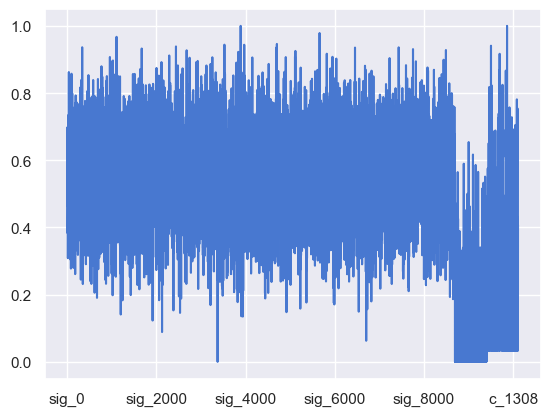

In [20]:
P1_norm.columns = ['c_'+str(x) for x in P1_norm.columns]
signals_df_norm.columns = ['sig_'+str(x) for x in signals_df_norm.columns]
df = signals_df_norm.join(P1_norm)
df.iloc[233,].plot()

<AxesSubplot:>

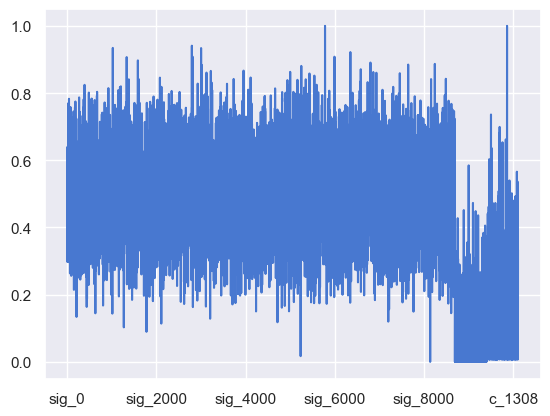

In [21]:
df.iloc[0,].plot()

### Train and evaluate a model

For the final step, let's train a simple classifier on our topological features. As usual we create training and validation sets

In [189]:
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    labels, 
                                                    test_size=0.1,
                                                    stratify = labels, 
                                                    random_state=2022)

### CNN Classifier

In [148]:
from tensorflow import keras

In [190]:
x_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
x_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [191]:
num_classes = len(np.unique(y_train))
num_classes

2

In [192]:
def make_model_paper(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, 
                                kernel_size=16, 
                                padding="same")(input_layer)
    conv1 = keras.layers.MaxPooling1D(pool_size=4, 
                                      strides=4, 
                                      padding="valid")(conv1)
    conv1 = keras.layers.Dense(64, 
                               activation="relu",
                               kernel_initializer=keras.initializers.Orthogonal())(conv1)
    #######
    conv11 = keras.layers.Conv1D(filters=128, 
                                kernel_size=16, 
                                padding="same")(conv1)
    conv11 = keras.layers.MaxPooling1D(pool_size=4, 
                                      strides=4, 
                                      padding="valid")(conv11)
    conv11 = keras.layers.Dense(128, 
                                activation="relu",
                                kernel_initializer=keras.initializers.Orthogonal())(conv11)
    ######
    conv12 = keras.layers.Conv1D(filters=256, 
                                kernel_size=16, 
                                padding="same")(conv11)
    conv12 = keras.layers.MaxPooling1D(pool_size=4, 
                                      strides=4, 
                                      padding="valid")(conv12)
    conv12 = keras.layers.Dense(256, 
                                activation="relu",
                                kernel_initializer=keras.initializers.Orthogonal())(conv12)
    #####
    ######
    conv13 = keras.layers.Conv1D(filters=512, 
                                kernel_size=32, 
                                padding="same")(conv12)
    conv13 = keras.layers.MaxPooling1D(pool_size=4, 
                                      strides=4, 
                                      padding="valid")(conv13)
    conv13 = keras.layers.Dense(512, 
                                activation="relu",
                                kernel_initializer=keras.initializers.Orthogonal())(conv13)
    #####

    '''conv2 = keras.layers.Conv1D(filters=64, 
                                kernel_size=3, 
                                padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, 
                                kernel_size=3, 
                                padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)'''

    #gap = keras.layers.GlobalAveragePooling1D()(conv12)
    flatten = keras.layers.Flatten()(conv13)

    mlp_layer1 = keras.layers.Dense(128, 
                                    activation="linear",
                                    kernel_initializer=keras.initializers.Orthogonal())(flatten)
    mlp_layer2 = keras.layers.Dense(128, 
                                    activation="relu",
                                    kernel_initializer=keras.initializers.Orthogonal())(mlp_layer1)
    mlp_layer3 = keras.layers.Dense(64, 
                                    activation="linear",
                                    kernel_initializer=keras.initializers.Orthogonal())(mlp_layer2)
    mlp_layer4 = keras.layers.Dense(64, 
                                    activation="relu",
                                    kernel_initializer=keras.initializers.Orthogonal())(mlp_layer3)
    output_layer = keras.layers.Dense(num_classes, 
                                      activation="linear")(mlp_layer4)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [198]:
def make_model_2(input_shape):
    input_layer = keras.layers.Input(input_shape)
    # layer - 1

    rec_layer_one = keras.layers.Bidirectional(keras.layers.LSTM(24, 
                                       #kernel_regularizer=keras.regularizers.l2(0.01), 
                                       #recurrent_regularizer=keras.regularizers.l2(0.01),
                                       return_sequences=True))(input_layer)

    #rec_layer_one = keras.layers.Dropout(0.15)(rec_layer_one)

    # layer - 2

    #rec_layer_two = keras.layers.Bidirectional(keras.layers.LSTM(64, 
    #                                   kernel_regularizer=keras.regularizers.l2(0.01), 
    #                                   recurrent_regularizer=keras.regularizers.l2(0.01)))(rec_layer_one)

    #rec_layer_two = keras.layers.Dropout(0.1)(rec_layer_two)


    gap = keras.layers.GlobalAveragePooling1D()(rec_layer_one)
    flatten = keras.layers.Flatten()(gap) #rec_layer_two

    mlp_layer1 = keras.layers.Dense(128, 
                                    activation="linear",
                                    kernel_initializer=keras.initializers.Orthogonal())(flatten)
    mlp_layer2 = keras.layers.Dense(256, 
                                    activation="relu",
                                    kernel_initializer=keras.initializers.Orthogonal())(mlp_layer1)
    mlp_layer3 = keras.layers.Dense(128, 
                                    activation="linear",
                                    kernel_initializer=keras.initializers.Orthogonal())(mlp_layer2)
    mlp_layer4 = keras.layers.Dense(64, 
                                    activation="relu",
                                    kernel_initializer=keras.initializers.Orthogonal())(mlp_layer3)
    output_layer = keras.layers.Dense(num_classes, 
                                      activation="sigmoid")(mlp_layer4)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

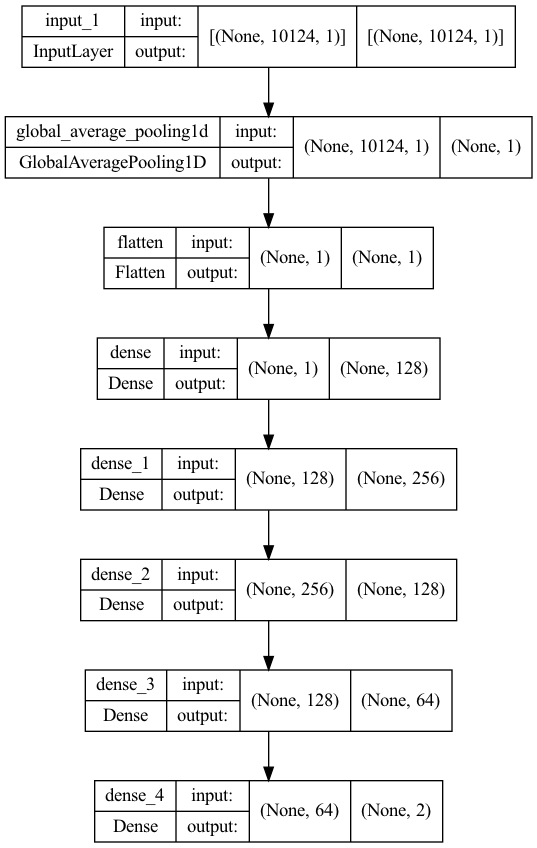

In [200]:
model = make_model_2(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [204]:
epochs = 5
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1),
]

In [202]:
rms = 'RMSprop'
sgd = keras.optimizers.SGD(learning_rate=0.1, 
                           decay=1e-6, 
                           momentum=0.65, 
                           nesterov=True)

model.compile(
    optimizer= sgd, #rms "adam"
    loss="mean_squared_error",
    metrics=["accuracy"],
)

In [205]:
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/5
66/66 [==============================] - 1s 6ms/step - loss: 0.2507 - accuracy: 0.4981 - val_loss: 0.2499 - val_accuracy: 0.4576 - lr: 0.1000
Epoch 2/5
66/66 [==============================] - 0s 2ms/step - loss: 0.2504 - accuracy: 0.4962 - val_loss: 0.2499 - val_accuracy: 0.6102 - lr: 0.1000
Epoch 3/5
66/66 [==============================] - 0s 2ms/step - loss: 0.2504 - accuracy: 0.5190 - val_loss: 0.2492 - val_accuracy: 0.5424 - lr: 0.1000
Epoch 4/5
66/66 [==============================] - 0s 2ms/step - loss: 0.2504 - accuracy: 0.4924 - val_loss: 0.2495 - val_accuracy: 0.5424 - lr: 0.1000
Epoch 5/5
66/66 [==============================] - 0s 2ms/step - loss: 0.2505 - accuracy: 0.4696 - val_loss: 0.2498 - val_accuracy: 0.5254 - lr: 0.1000


In [206]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

3/3 [==============================] - 0s 2ms/step - loss: 0.2499 - accuracy: 0.5077
Test accuracy 0.5076923370361328
Test loss 0.24993963539600372


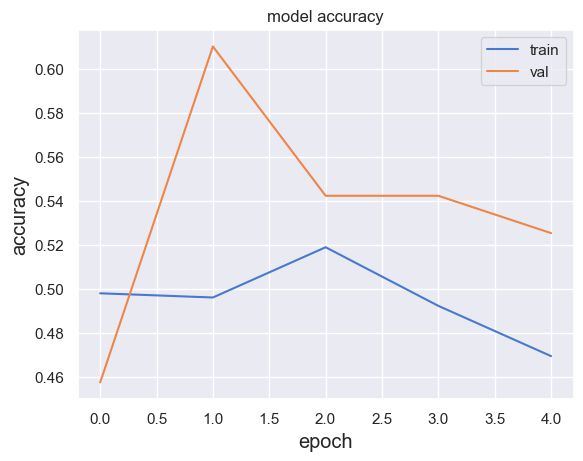

In [207]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [208]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_test)[:, 1]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

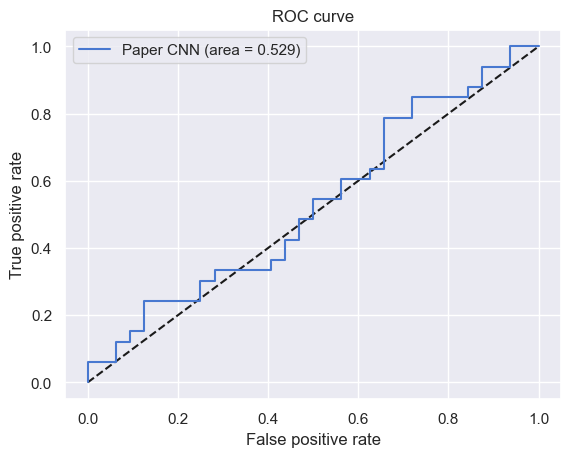

In [209]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Paper CNN (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [199]:
keras.backend.clear_session()

## Mapper

In [22]:
import kmapper as km
from kmapper.jupyter import display
import umap
import sklearn
import sklearn.manifold as manifold

In [23]:
# initialize mapper
mapper = km.KeplerMapper(verbose=1)

KeplerMapper(verbose=1)


In [47]:
mapper2 = km.KeplerMapper(verbose=1)

KeplerMapper(verbose=1)


In [24]:
data_tr = df.T

In [48]:
p_data_df = mapper2.fit_transform(df,
                              projection=[manifold.Isomap(n_components=100,
                                                          n_jobs=-1), umap.UMAP(n_components=2,
                                                                                random_state=2022)])

..Composing projection pipeline of length 2:
	Projections: Isomap(n_components=100, n_jobs=-1)
		UMAP(random_state=2022)
	Distance matrices: False
False
	Scalers: MinMaxScaler()
MinMaxScaler()
..Projecting on data shaped (1000, 10108)

..Projecting data using: 
	Isomap(n_components=100, n_jobs=-1)


..Scaling with: MinMaxScaler()

..Projecting on data shaped (1000, 100)

..Projecting data using: 
	UMAP(random_state=2022, verbose=1)

UMAP(random_state=2022, verbose=1)
Tue Dec 13 18:55:41 2022 Construct fuzzy simplicial set
Tue Dec 13 18:55:41 2022 Finding Nearest Neighbors
Tue Dec 13 18:55:44 2022 Finished Nearest Neighbor Search
Tue Dec 13 18:55:45 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Dec 13 18:55:47 2022 Finished embedding

..Scaling with: MinMaxScaler()



In [25]:
p_data = mapper.fit_transform(df,
                              projection=[manifold.Isomap(n_components=100,
                                                          n_jobs=-1), umap.UMAP(n_components=2,
                                                                                random_state=2022)])

..Composing projection pipeline of length 2:
	Projections: Isomap(n_components=100, n_jobs=-1)
		UMAP(random_state=2022)
	Distance matrices: False
False
	Scalers: MinMaxScaler()
MinMaxScaler()
..Projecting on data shaped (10108, 1000)

..Projecting data using: 
	Isomap(n_components=100, n_jobs=-1)


..Scaling with: MinMaxScaler()

..Projecting on data shaped (10108, 100)

..Projecting data using: 
	UMAP(random_state=2022, verbose=1)

UMAP(random_state=2022, verbose=1)
Tue Dec 13 17:27:12 2022 Construct fuzzy simplicial set
Tue Dec 13 17:27:12 2022 Finding Nearest Neighbors
Tue Dec 13 17:27:12 2022 Building RP forest with 10 trees
Tue Dec 13 17:27:17 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Tue Dec 13 17:27:29 2022 Finished Nearest Neighbor Search
Tue Dec 13 17:27:32 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Dec 13 17:27:40 2022 Finished embedding

..Scaling with: MinMaxScaler()



In [ ]:
p_data[2]

In [49]:
# cluster data using DBSCAN
G = mapper.map(p_data_df, df, clusterer=sklearn.cluster.DBSCAN(metric="cosine"))

Mapping on data shaped (1000, 10108) using lens shaped (1000, 2)

Creating 100 hypercubes.

Created 64 edges and 58 nodes in 0:00:00.382292.


In [30]:
data_tr.shape, labels.shape

((10108, 1000), (1000,))

In [39]:
proms = []
for i in range(0,len(data_tr)):
    prom_i = np.mean(data_tr.iloc[i]) + 1
    proms.append(prom_i)

In [45]:
len(df.columns.to_numpy())

10108

In [50]:
# visualize graph
mapper.visualize(G, 
                path_html="mapper_example_"+".html",
                title='GW',
                custom_tooltips = data_tr.columns.to_numpy(),
                color_values = labels,#np.log(proms), #per_return+1
                color_function_name = 'Detection',
                node_color_function = np.array(['average', 'std', 'sum', 'max', 'min']))

# display mapper in jupyter
km.jupyter.display("mapper_example_"+".html")

Wrote visualization to: mapper_example_.html


/Users/anieto/miniconda3/envs/tda/lib/python3.7/site-packages/kmapper/visuals.py:344: RuntimeWarning: invalid value encountered in long_scalars
  height = np.floor(((bar / max_bucket_value) * 100) + 0.5)
/Users/anieto/miniconda3/envs/tda/lib/python3.7/site-packages/kmapper/visuals.py:345: RuntimeWarning: invalid value encountered in long_scalars
  perc = round((bar / sum_bucket_value) * 100.0, 1)


/Users/anieto/miniconda3/envs/tda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [59]:
g_waves = np.where((labels>0))

In [63]:
node

[99, 267, 337, 411, 435, 466, 663, 724, 866]

In [64]:
intersection = np.intersect1d(node, g_waves)
intersection

array([ 99, 411, 435, 663])

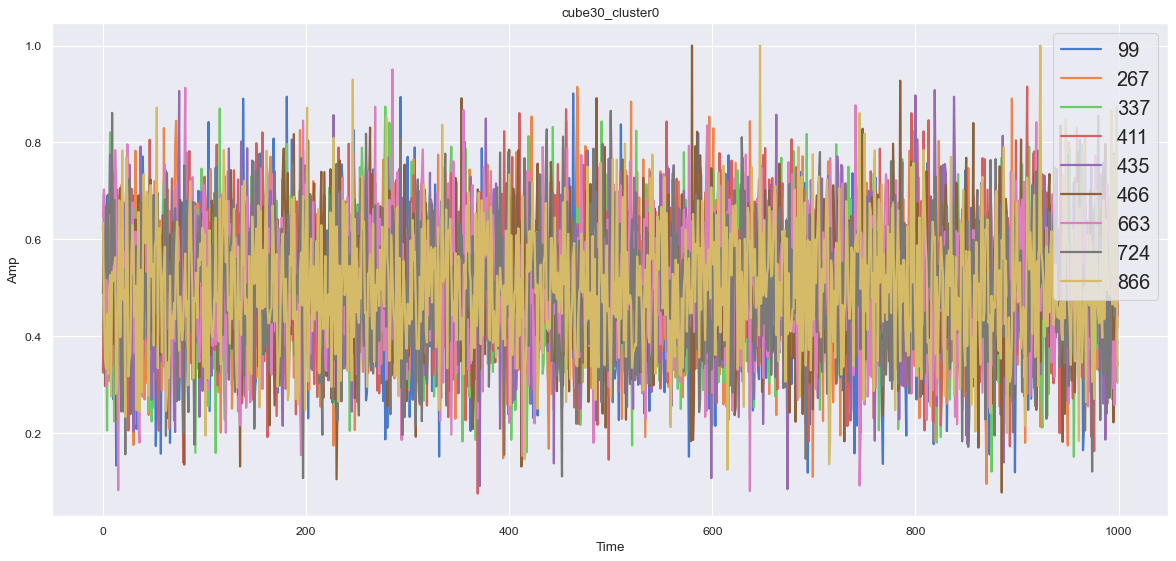

In [62]:
nodeid = 'cube30_cluster0'
node = G['nodes'][nodeid]


plt.figure(figsize=(18, 8), dpi=80)
plt.rcParams.update({'font.size': 22})

for i in node:
    plt.plot(df.iloc[:,i], linewidth=2)
    
plt.legend(list(data_tr.columns[node]), fontsize=18)
plt.xlabel('Time')
plt.ylabel('Amp')
plt.title(nodeid)

plt.savefig("mapper_example_"+".png", dpi='figure', format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')

# Conclusiones

* No es tan facil...
* encaje de 200 y pca de 3 dimensiones podría cambiarse
* La red convolucional no parece funcionar
* mas series implica necesidad de recursos de computo...
* no parece ser tan cierto el resultado!